# Часть 3. Прогнозирование ряда со сложной сезонностью.

В записке реализована печать в отдельном окне с возможностью прокрутки для наглядности - фунция window_plot.
 Использовалась библиотека holidays.

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import statsmodels.api as sm
import holidays

from matplotlib import pylab as plt
from scipy import stats as sts
from itertools import product
from joblib import dump, load
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

### 1. Чтение данных, выбор ячейки.

Рассматриваем данные за перод с декабря 2015 года по май 2016 года. Выберем ячейку содержащую Empire State Building.

In [2]:
main_dir = os.path.dirname(os.path.dirname(os.path.abspath('file')))
filename = os.path.join(main_dir, '2015_12_2016_05.csv')
filename

'/home/artem/data_science/yandex_data/course_6/TAXI/2015_12_2016_05.csv'

In [3]:
data = pd.read_csv(filename, sep=',', header=0)
data.head()

region       west       east      south      north  2015-12-01 00:00:00  \
0    1075 -74.022246 -74.011135  40.697437  40.705825                 19.0   
1    1076 -74.022246 -74.011135  40.705825  40.714213                 43.0   
2    1077 -74.022246 -74.011135  40.714213  40.722601                 26.0   
3    1122 -74.011135 -74.000023  40.672272  40.680660                  0.0   
4    1125 -74.011135 -74.000023  40.697437  40.705825                 76.0   

   2015-12-01 01:00:00  2015-12-01 02:00:00  2015-12-01 03:00:00  \
0                 16.0                  8.0                  3.0   
1                 22.0                 19.0                 12.0   
2                 12.0                  3.0                  5.0   
3                  0.0                  0.0                  0.0   
4                 29.0                  9.0                  7.0   

   2015-12-01 04:00:00  ...  2016-05-31 14:00:00  2016-05-31 15:00:00  \
0                  2.0  ...                124.0                105.0   
1                 12.0  ...                214.0                208.0   
2                  3.0  ...                104.0                 69.0   
3                  1.0  ...                  3.0                  0.0   
4                  7.0  ...                 96.0                 70.0   

   2016-05-31 16:00:00  2016-05-31 17:00:00  2016-05-31 18:00:00  \
0                 80.0                 84.0                106.0   
1                156.0                202.0                213.0   
2                 67.0                109.0                173.0   
3                  1.0                  3.0                  2.0   
4                 68.0                109.0                126.0   

   2016-05-31 19:00:00  2016-05-31 20:00:00  2016-05-31 21:00:00  \
0                106.0                 99.0                 84.0   
1                167.0                166.0                173.0   
2                171.0                165.0                107.0   
3                  3.0                  1.0                  0.0   
4                 88.0                 65.0                 78.0   

   2016-05-31 22:00:00  2016-05-31 23:00:00  
0                 83.0                 34.0  
1                 98.0                 77.0  
2                127.0                 58.0  
3                  0.0                  1.0  
4                 94.0                 53.0  

[5 rows x 4397 columns]

In [4]:
# Координаты Empire State Building.
longitude = -73.985428
latitude = 40.748817

# Ищем ячейку
cell = data[(data.west <= longitude) & 
           (data.east >= longitude) & 
           (data.south <= latitude) & 
           (data.north >= latitude)]

# Получаем значения.
trips = np.array(cell).reshape((-1,))[5:]
labels = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in list(cell.columns[5:])]

### 2. Функции для печати.

In [5]:
import math
import sys
if sys.version_info[0] < 3:
  from Tkinter import Tk, Button, Frame, Canvas, Scrollbar
  import Tkconstants
else:
  from tkinter import Tk, Button, Frame, Canvas, Scrollbar
  import tkinter.constants as Tkconstants

import matplotlib
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.dates as mdates
import pprint, inspect

In [6]:
def addScrollingFigure(figure, frame):
    
    global canvas, mplCanvas, interior, interior_id, cwid
    
    # set up a canvas with scrollbars
    canvas = Canvas(frame)
    canvas.grid(row=1, column=1, sticky=Tkconstants.NSEW)

    xScrollbar = Scrollbar(frame, orient=Tkconstants.HORIZONTAL)
    yScrollbar = Scrollbar(frame)

    xScrollbar.grid(row=2, column=1, sticky=Tkconstants.EW)
    yScrollbar.grid(row=1, column=2, sticky=Tkconstants.NS)

    canvas.config(xscrollcommand=xScrollbar.set)
    xScrollbar.config(command=canvas.xview)
    canvas.config(yscrollcommand=yScrollbar.set)
    yScrollbar.config(command=canvas.yview)

    # plug in the figure
    figAgg = FigureCanvasTkAgg(figure, canvas)
    mplCanvas = figAgg.get_tk_widget()

    # and connect figure with scrolling region
    cwid = canvas.create_window(0, 0, window=mplCanvas, anchor=Tkconstants.NW)
    changeSize(figure, 1)

def changeSize(figure, factor):
    global canvas, mplCanvas, interior, interior_id, frame, cwid
    oldSize = figure.get_size_inches()
    figure.set_size_inches([factor * s for s in oldSize])
    wi,hi = [i*figure.dpi for i in figure.get_size_inches()]
    mplCanvas.config(width=wi, height=hi) # ; printBboxes("A")
    canvas.itemconfigure(cwid, width=wi, height=hi)# ; printBboxes("B")
    canvas.config(scrollregion=canvas.bbox(Tkconstants.ALL),width=200,height=200)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(item.get_fontsize()*factor)
    ax.xaxis.labelpad = ax.xaxis.labelpad*factor
    ax.yaxis.labelpad = ax.yaxis.labelpad*factor
    #figure.tight_layout() # matplotlib > 1.1.1
    figure.subplots_adjust(left=0.2, bottom=0.15, top=0.86)
    figure.canvas.draw() #; printBboxes("C")

In [7]:
def window_plot(labels, trips, min_lim=None, max_lim=None, title=''):
    """
    Печать в оддельном окне с возможностью прокрутки.
    @param:
    labels -список с datetime.datetime объектами
    min_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Минимальная дата отрисовки
    max_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Максимальная дата отрисовки
    title - заголовок
    """
    
    global root, figure, frame, canvas, ax
    
    frame = None
    canvas = None
    ax = None
    
    if min_lim is None:
        min_lim = labels[0]
    else:
        min_lim = datetime.datetime.strptime(min_lim, '%Y-%m-%d %H:%M:%S')
    
    if max_lim is None:
        max_lim = labels[-1]
    else:
        max_lim = datetime.datetime.strptime(max_lim, '%Y-%m-%d %H:%M:%S')
    
    root = Tk()
    root.rowconfigure(1, weight=1)
    root.columnconfigure(1, weight=1)

    frame = Frame(root)
    frame.grid(column=1, row=1, sticky=Tkconstants.NSEW)
    frame.rowconfigure(1, weight=1)
    frame.columnconfigure(1, weight=1)
    
    
    figure = plt.figure(dpi=100, figsize=(60, 4))
    ax = figure.add_subplot(111)
    ax.plot(labels, trips)
    ax.set_xlim(min_lim, max_lim)
    ax.set_title(title)
    ax.set_xlabel('Trips')
    ax.set_ylabel('Hours')
    
    month = mdates.MonthLocator()
    month_format = mdates.DateFormatter('%Y-%m')
    week_day = mdates.WeekdayLocator()
    ax.xaxis.set_major_locator(month)
    ax.xaxis.set_major_formatter(month_format)
    ax.xaxis.set_minor_locator(week_day)
    ax.grid(True)
    
    addScrollingFigure(figure, frame)

    buttonFrame = Frame(root)
    buttonFrame.grid(row=1, column=2, sticky=Tkconstants.NS)
    biggerButton = Button(buttonFrame, text="larger",
                        command=lambda : changeSize(figure, 1.2))
    biggerButton.grid(column=1, row=1)
    smallerButton = Button(buttonFrame, text="smaller",
                         command=lambda : changeSize(figure, 0.833))
    smallerButton.grid(column=1, row=2)
    qButton = Button(buttonFrame, text="quit",
                         command=lambda :  sys.exit(0))
    qButton.grid(column=1, row=3)

    root.mainloop()

In [8]:
# Так себе печать.
def simple_plot(labels, trips, min_lim=None, max_lim=None, title=''):
    """
    labels -список с datetime.datetime объектами
    min_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Минимальная дата отрисовки
    max_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Максимальная дата отрисовки
    title - заголовок
    """
    month = mdates.MonthLocator()
    month_format = mdates.DateFormatter('%Y-%m')
    week_day = mdates.WeekdayLocator()
    
    
    if min_lim is None:
        min_lim = labels[0]
    else:
        min_lim = datetime.datetime.strptime(min_lim, '%Y-%m-%d %H:%M:%S')
    
    if max_lim is None:
        max_lim = labels[-1]
    else:
        max_lim = datetime.datetime.strptime(max_lim, '%Y-%m-%d %H:%M:%S')
    
    fig, ax = plt.subplots(figsize=(30, 8))
    ax.plot(labels, trips)
    ax.set_xlabel('Hours', fontsize=15)
    #plt.xticks(plot_hours[::label_step], plot_labels[::label_step], rotation='vertical')
    ax.set_ylabel('Trips', fontsize=15)
    ax.xaxis.set_major_locator(month)
    ax.xaxis.set_major_formatter(month_format)
    ax.xaxis.set_minor_locator(week_day)
    """
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('left')
    """
    ax.grid(True)
    ax.set_xlim(min_lim, max_lim)
    ax.set_title(title, fontsize=30, y=1.01)

Построим графики по среднесуточному количеству поездок.

In [9]:
# Преобразование в среднее по суткам. Используем только для визуализации.
def mid_day(trips):
    mid_trips = []
    ids = list(range(0,len(trips)+1,24))
    ex_id = 0
    for i in ids:
        if i == 0:
            continue
        mid_trips.append(trips[ex_id:i].mean())
        ex_id = i
    return np.array(mid_trips)

In [10]:
# Преобразование в среднее по неделям. Используем только для визуализации.
def mid_week(trips):
    mid_trips = []
    ids = list(range(0,len(trips)+1,24))
    ex_id = 0
    for i in ids:
        if i == 0:
            continue
        mid_trips.append(trips[ex_id:i].mean())
        ex_id = i
    return np.array(mid_trips)

In [11]:
mid_trips = mid_day(trips)
mid_labels = np.array([labels[i] for i in range(0,len(labels), 24)])

##### График за два месяца. Печать в одельном окне.

/home/artem/data_science/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


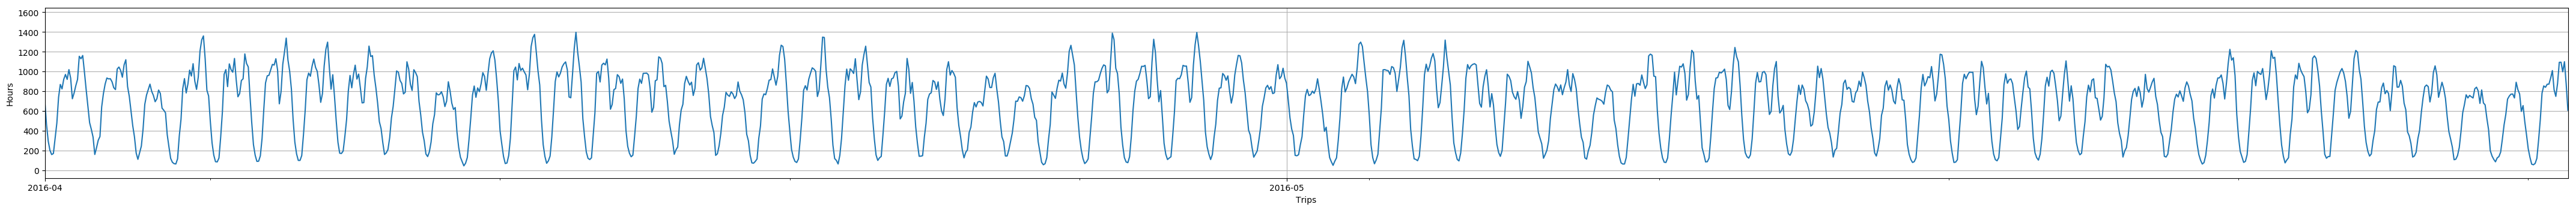

In [12]:
window_plot(labels, trips, min_lim='2016-04-01 00:00:00')

Наблюдаем суточную и недельную сезонность.

##### График за весь период.

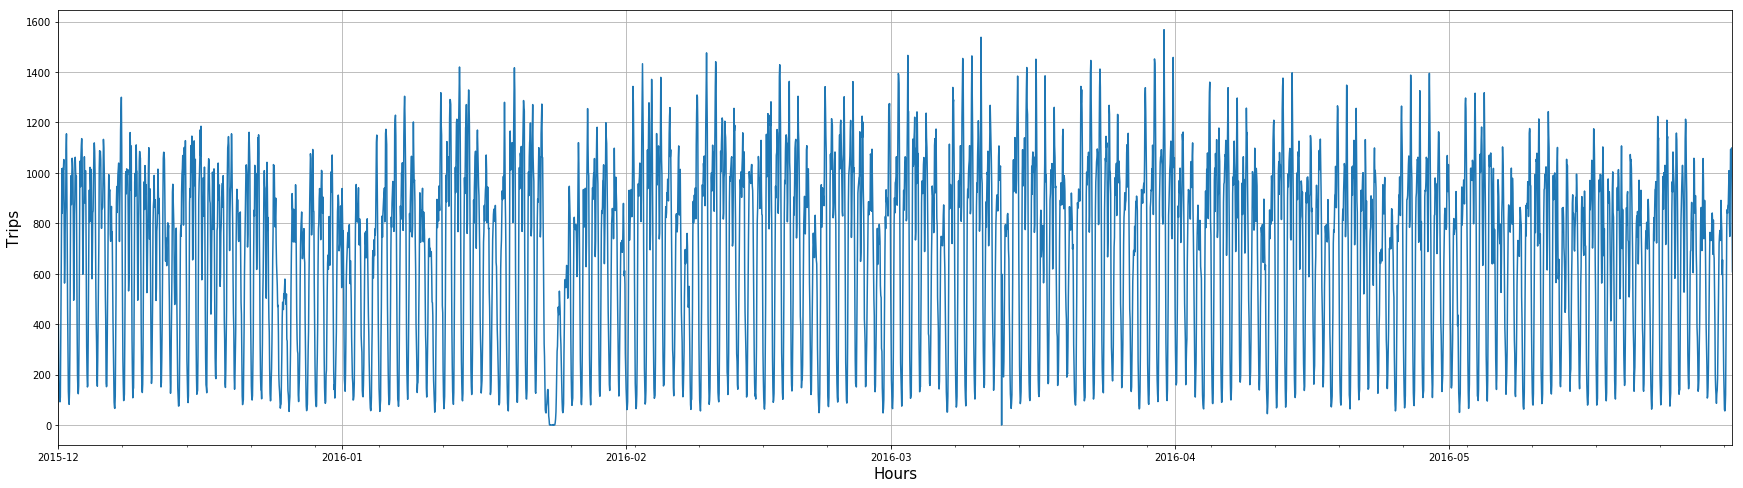

In [49]:
simple_plot(labels, trips)

Итого получили недельную и суточную сезонность.

### 3. Регрессия.

In [14]:
from sklearn import linear_model, model_selection, metrics

In [15]:
cell_data = pd.DataFrame(trips, index=labels, columns=['trips'])
cell_data.head()

trips
2015-12-01 00:00:00  394.0
2015-12-01 01:00:00  185.0
2015-12-01 02:00:00  109.0
2015-12-01 03:00:00  100.0
2015-12-01 04:00:00   92.0

Для начала помотрим на сглаженный график.

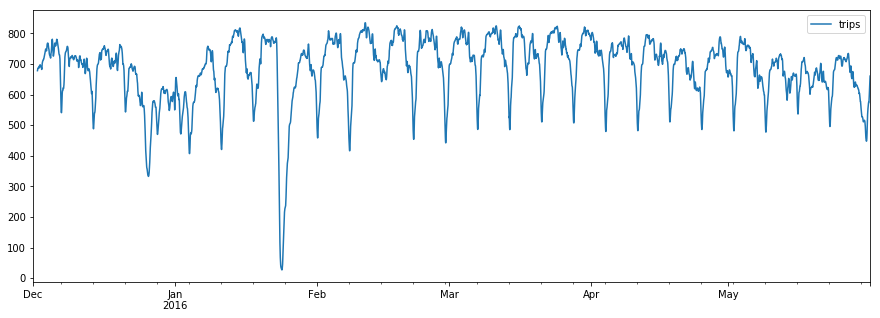

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
cell_data.rolling(24).mean().plot(ax=ax)
plt.show()

Для учёта недельной сезонности используем регрессионные признаки следующего вида:

$$
s_i = \sin \left( [1,\dots,T] * 2 \pi i/ 8766 \right),\space c_i = \cos \left( [1,\dots,T] * 2 \pi i/ 8766
\right), i=1,\dots, K
$$

In [17]:
# Добавление признаков. 
# Модифицирует датафрейм, возвращеет имена колонок с признаками.
def add_features(cell_data, k):
    
    # Синусы и косинусы.
    cell_data['const'] = 1
    cell_data['lin'] = np.arange(1, cell_data.shape[0]+1)
    real_columns = ['const', 'lin']
    for i in range(1, k+1):
        #year_sin_col = 'year_sin_{}'.format(i)
        #year_cos_col = 'year_cos_{}'.format(i)
        week_sin_col = 'week_sin_{}'.format(i)
        week_cos_col = 'week_cos_{}'.format(i)
        
        #cell_data[year_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 8766))
        #cell_data[year_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 8766))
        cell_data[week_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 168))
        cell_data[week_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 168))
        
        #features_columns += [year_sin_col, year_cos_col, week_sin_col, week_cos_col]
        real_columns += [week_sin_col, week_cos_col]
    
    
    return real_columns

In [18]:
# Обучение модели, добаление предсказаний и остатков в датафрейм. Возвращает предсказанные значения.
def get_reg_pred(cell_data, features_columns):
    train_data = np.array(cell_data[features_columns])
    train_labels = np.array(cell_data['trips'])
    
    model = linear_model.LinearRegression()
    model.fit(train_data, train_labels)
    
    preds = model.predict(cell_data[features_columns])
    
    cell_data['reg_pred'] = preds
    cell_data['reg_resid'] = cell_data['trips'] - preds
    
    return preds

Подберём К.

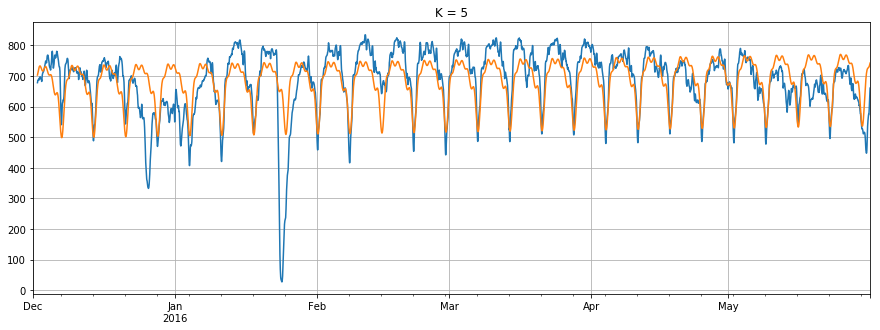

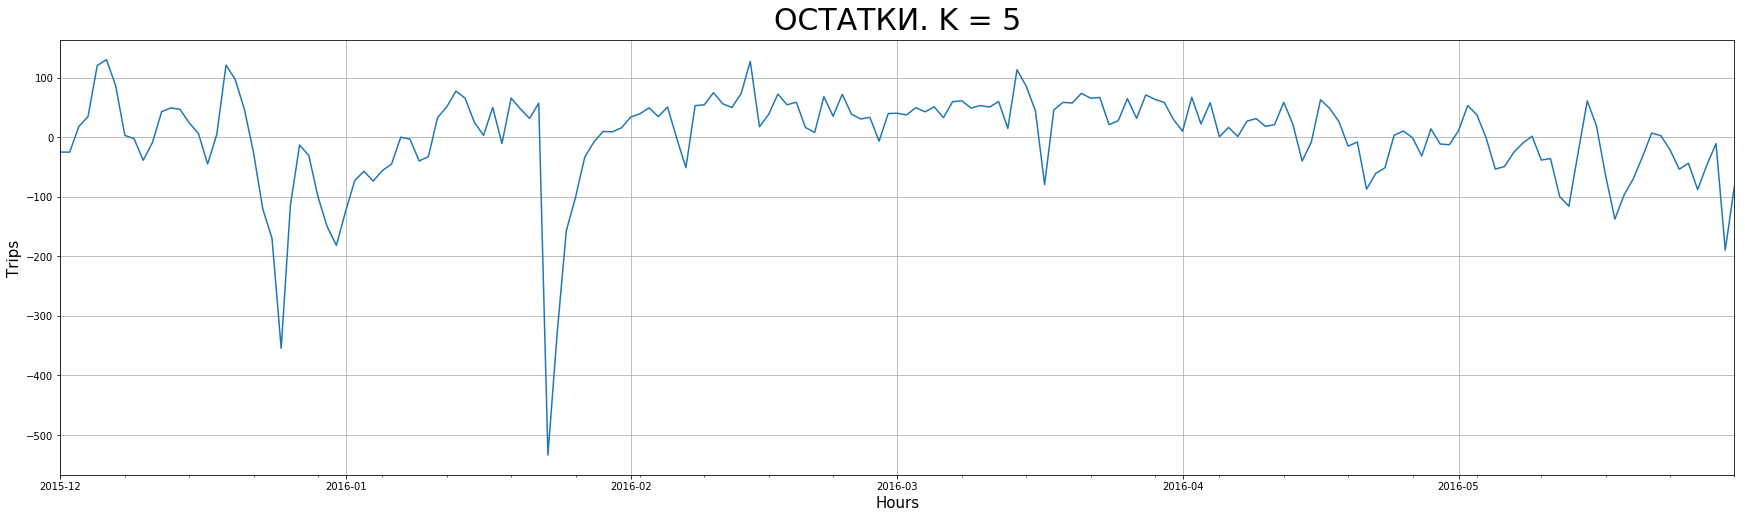

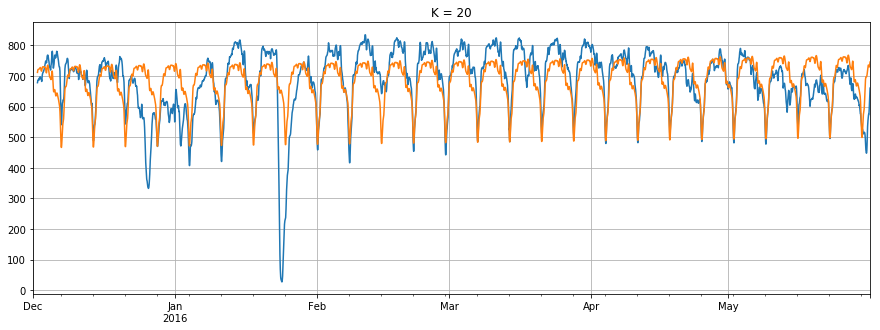

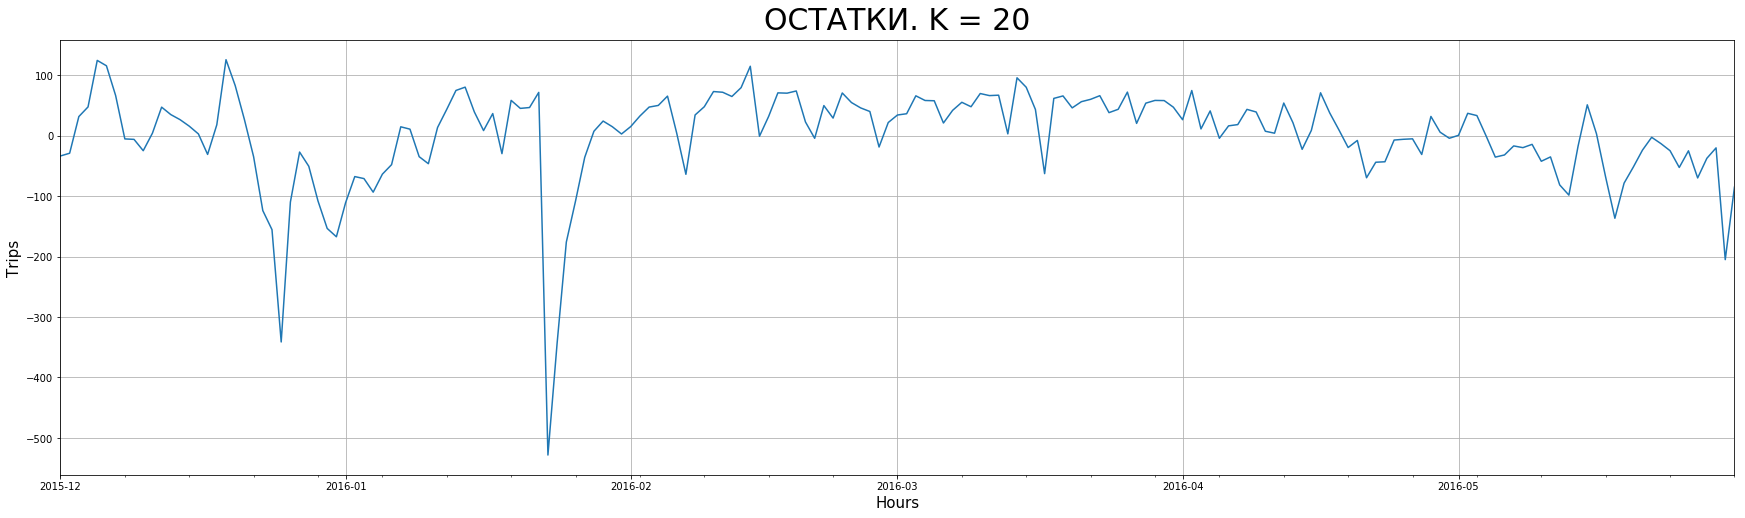

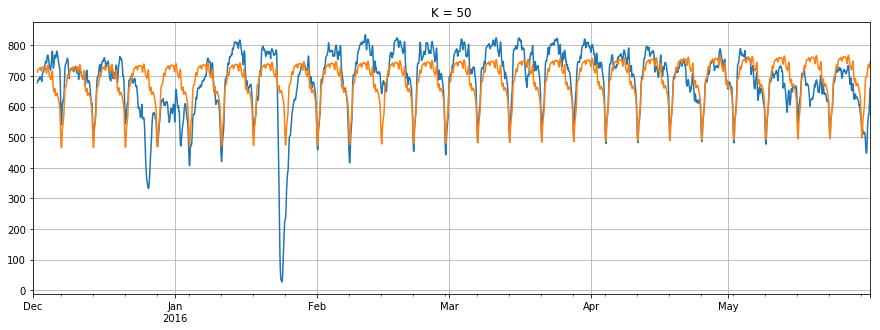

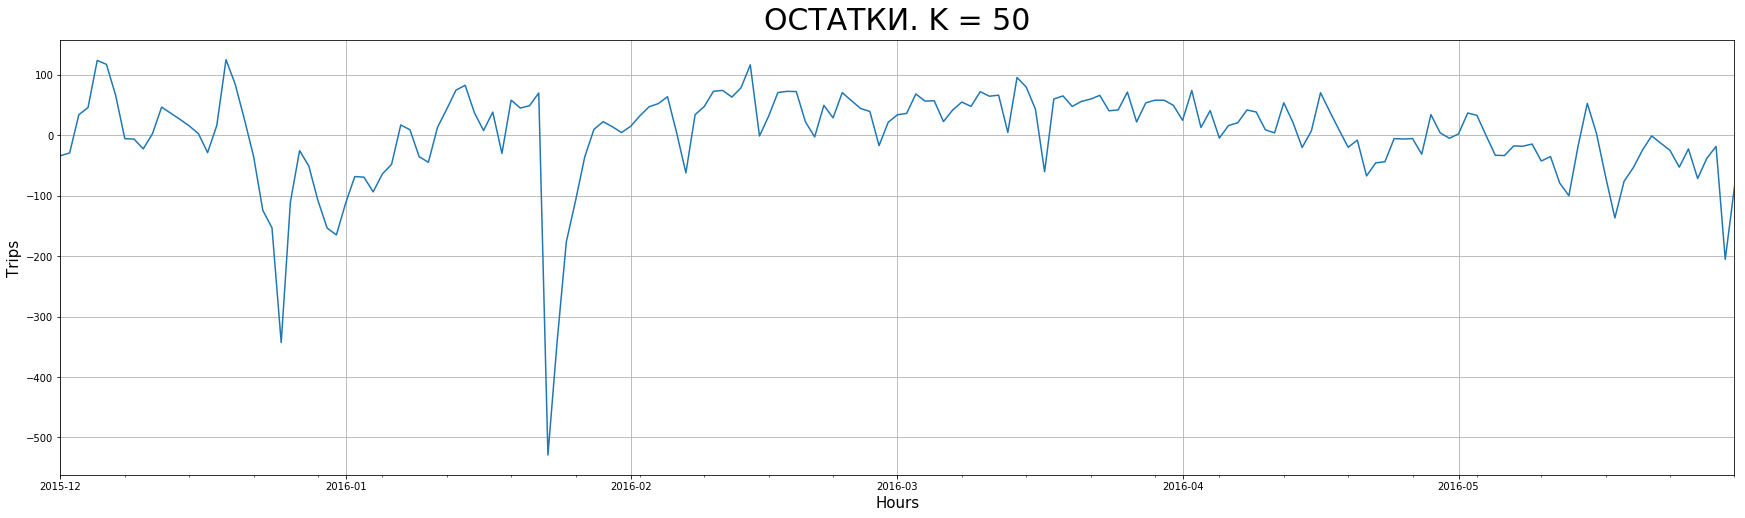

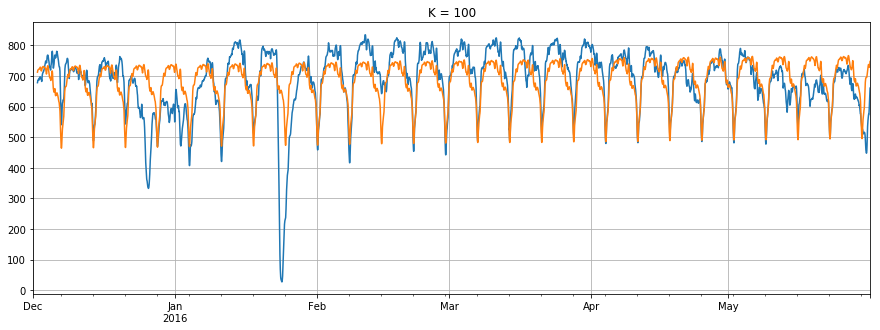

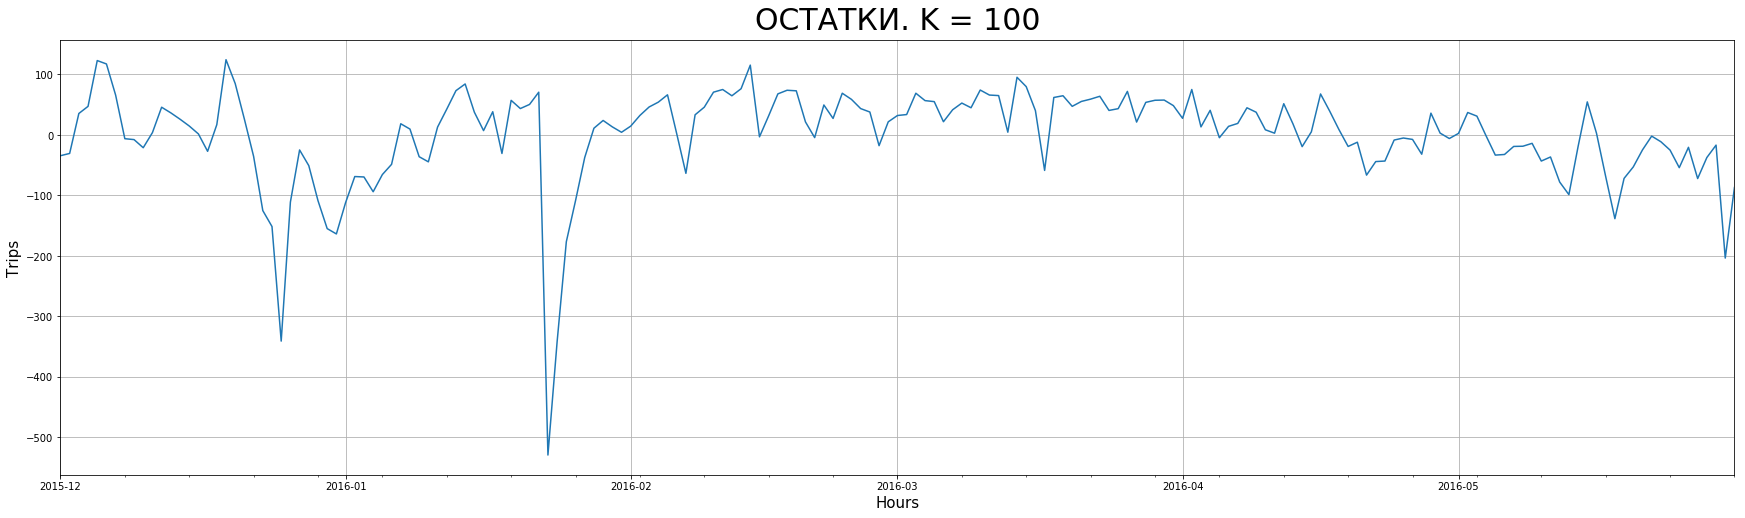

In [19]:
ks = [5, 20, 50, 100]
for k in ks:
    features_columns = add_features(cell_data, k)
    reg_pred = get_reg_pred(cell_data, features_columns)
    
    # Печать.
    fig, ax = plt.subplots(figsize=(15, 5))
    cell_data['trips'].rolling(24).mean().plot(ax=ax)
    cell_data['reg_pred'].rolling(24).mean().plot(ax=ax)
    ax.set_title('K = {}'.format(k))
    plt.grid(True)
    simple_plot(mid_labels, mid_day(np.array(cell_data['reg_resid'])), title='ОСТАТКИ. K = {}'.format(k))
    plt.show()
    
    cell_data.drop(columns=features_columns + ['reg_pred', 'reg_resid'], inplace=True)

Примем К=5.

In [20]:
K = 5
features_columns = add_features(cell_data, K)
reg_pred = get_reg_pred(cell_data, features_columns)
cell_data['reg_resid'] = cell_data['trips'] - reg_pred
cell_data.head()

trips  const  lin  week_sin_1  week_cos_1  week_sin_2  \
2015-12-01 00:00:00  394.0      1    1    0.037391    0.999301    0.074730   
2015-12-01 01:00:00  185.0      1    2    0.074730    0.997204    0.149042   
2015-12-01 02:00:00  109.0      1    3    0.111964    0.993712    0.222521   
2015-12-01 03:00:00  100.0      1    4    0.149042    0.988831    0.294755   
2015-12-01 04:00:00   92.0      1    5    0.185912    0.982566    0.365341   

                     week_cos_2  week_sin_3  week_cos_3  week_sin_4  \
2015-12-01 00:00:00    0.997204    0.111964    0.993712    0.149042   
2015-12-01 01:00:00    0.988831    0.222521    0.974928    0.294755   
2015-12-01 02:00:00    0.974928    0.330279    0.943883    0.433884   
2015-12-01 03:00:00    0.955573    0.433884    0.900969    0.563320   
2015-12-01 04:00:00    0.930874    0.532032    0.846724    0.680173   

                     week_cos_4  week_sin_5  week_cos_5    reg_pred  \
2015-12-01 00:00:00    0.988831    0.185912    0.982566  683.162669   
2015-12-01 01:00:00    0.955573    0.365341    0.930874  678.250287   
2015-12-01 02:00:00    0.900969    0.532032    0.846724  673.905990   
2015-12-01 03:00:00    0.826239    0.680173    0.733052  670.383784   
2015-12-01 04:00:00    0.733052    0.804598    0.593820  667.895050   

                      reg_resid  
2015-12-01 00:00:00 -289.162669  
2015-12-01 01:00:00 -493.250287  
2015-12-01 02:00:00 -564.905990  
2015-12-01 03:00:00 -570.383784  
2015-12-01 04:00:00 -575.895050

### 4. ARIMA

В ариму бедем подовать только остатки от регрессии, без указания exog.

Сделаем декомпозицию остатков после регрессии.

In [21]:
# Печать декомпозиции.
def dec_plot(pd_series):
    dec_obj = sm.tsa.seasonal_decompose(pd_series)
    simple_plot(np.array(pd_series.index)[::24][:len(mid_day(dec_obj.observed))], 
                mid_day(dec_obj.observed), title='Obs')
    simple_plot(np.array(pd_series.index)[::24][:len(mid_day(dec_obj.trend))], 
                mid_day(dec_obj.trend), title='Trend')
    simple_plot(np.array(pd_series.index), np.array(dec_obj.seasonal), title='Seasonal')
    simple_plot(np.array(pd_series.index)[::24][:len(mid_day(dec_obj.observed))], 
                mid_day(dec_obj.resid), title='Resid')
    return dec_obj

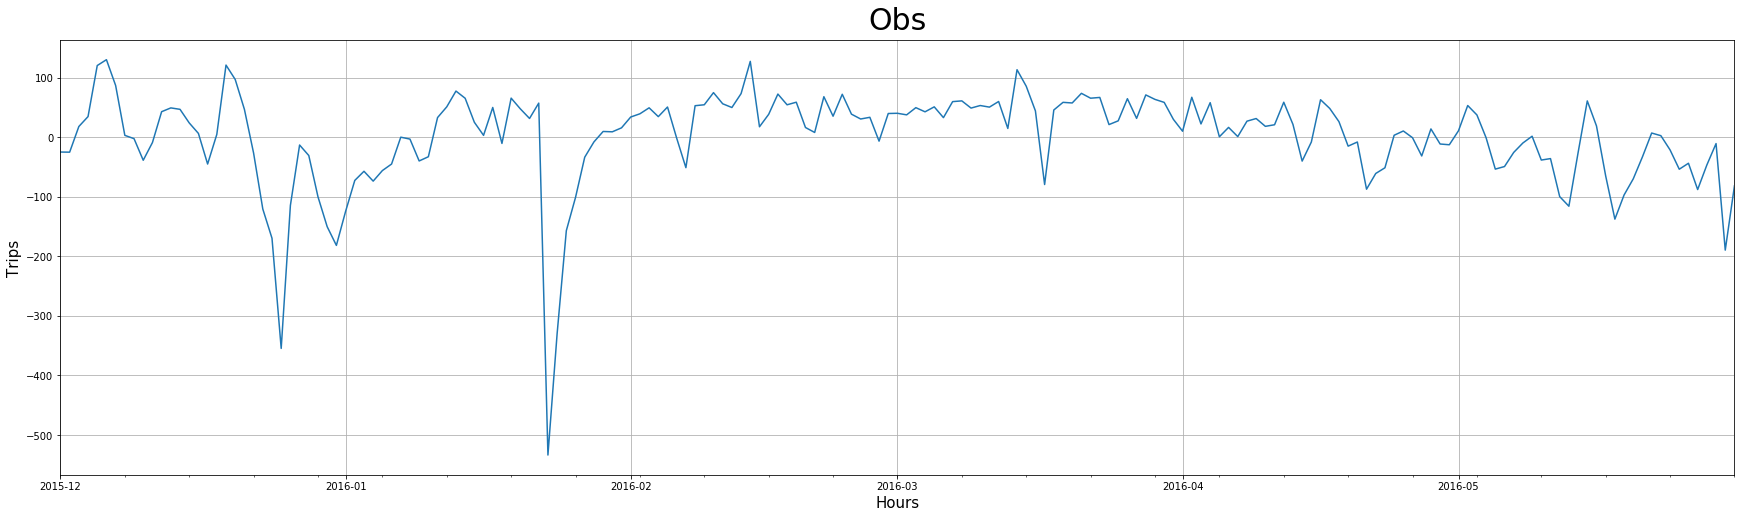

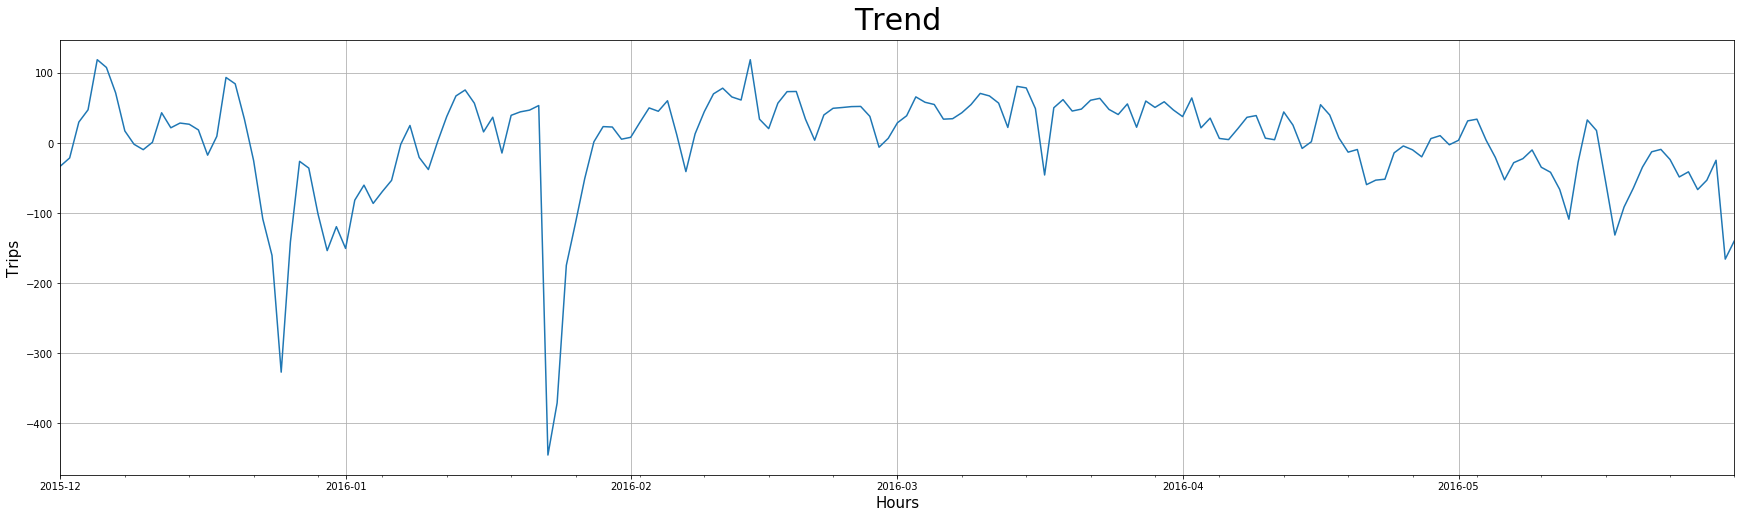

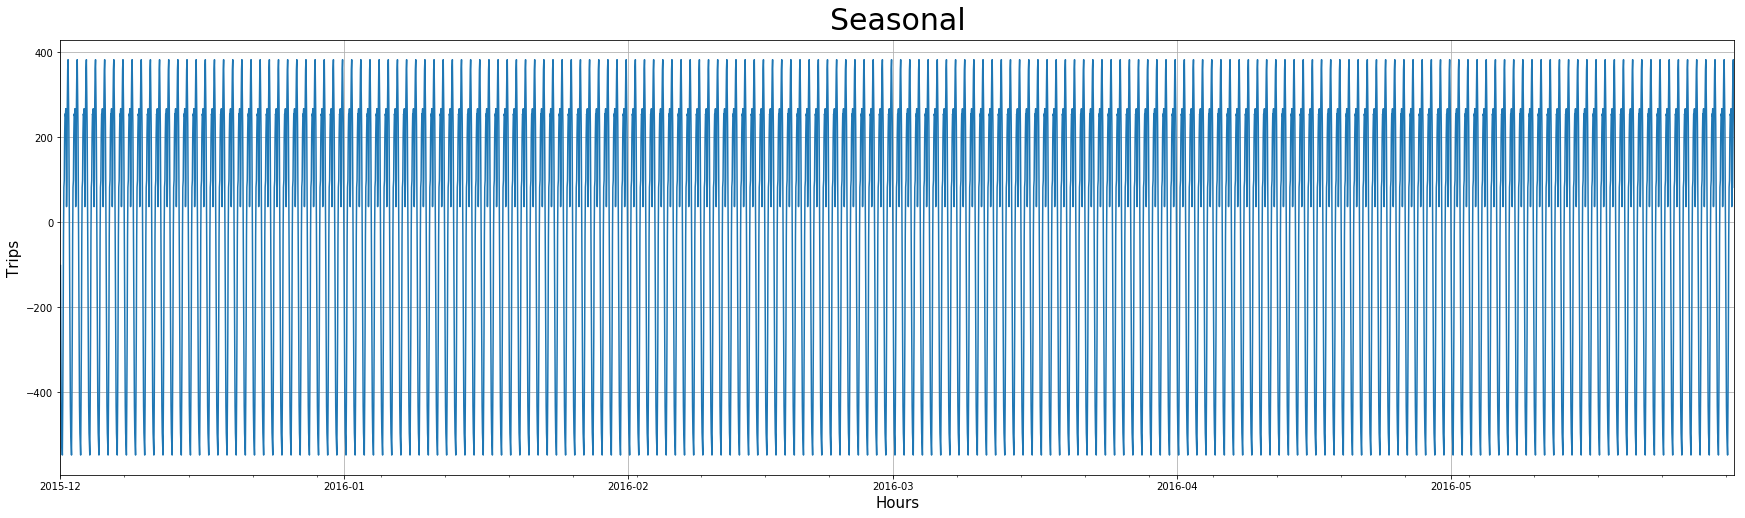

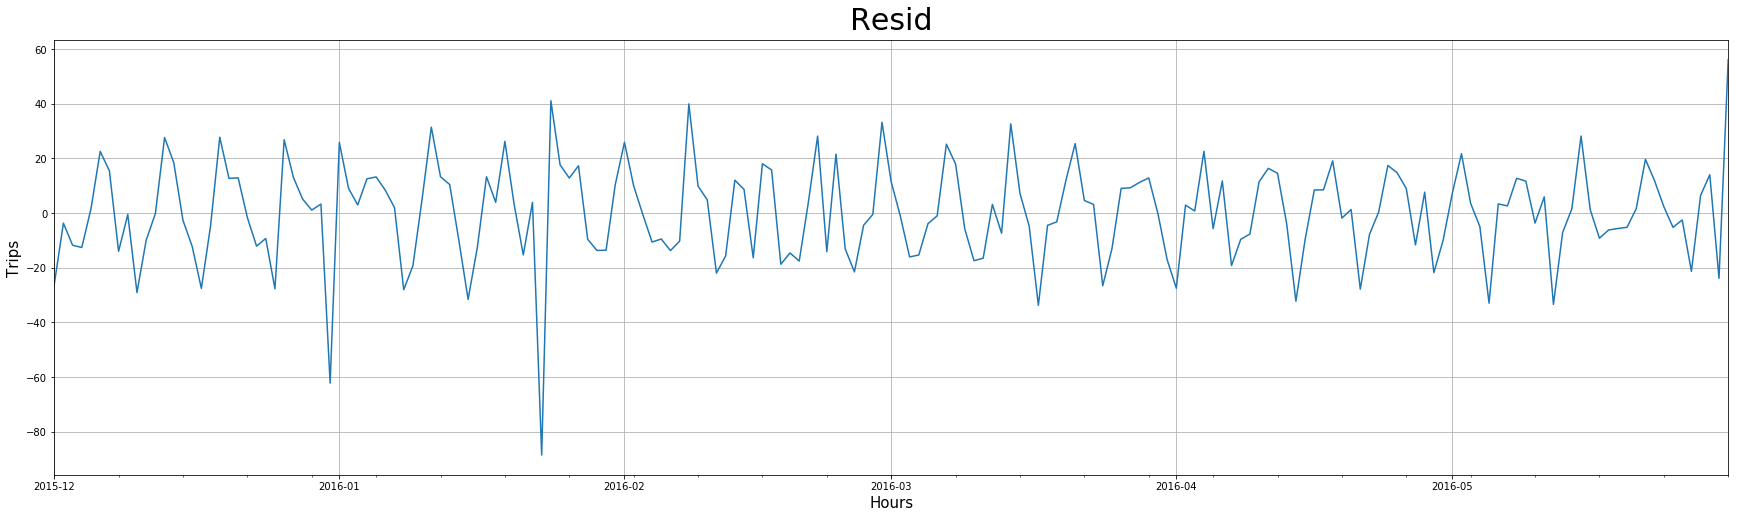

In [22]:
_ = dec_plot(cell_data['reg_resid'])

Два раза продифференцируем по cуточной сезонности. Затем применим обычное дифференцирование.

In [23]:
diff_period = 24
resid_col = 'reg_resid'
diff_col = 'reg_resid_diff' 
cell_data[diff_col] = cell_data[resid_col] - cell_data[resid_col].shift(diff_period)
cell_data[diff_col] = cell_data[diff_col] - cell_data[diff_col].shift(diff_period)
cell_data[diff_col] = cell_data[diff_col] - cell_data[diff_col].shift(1)

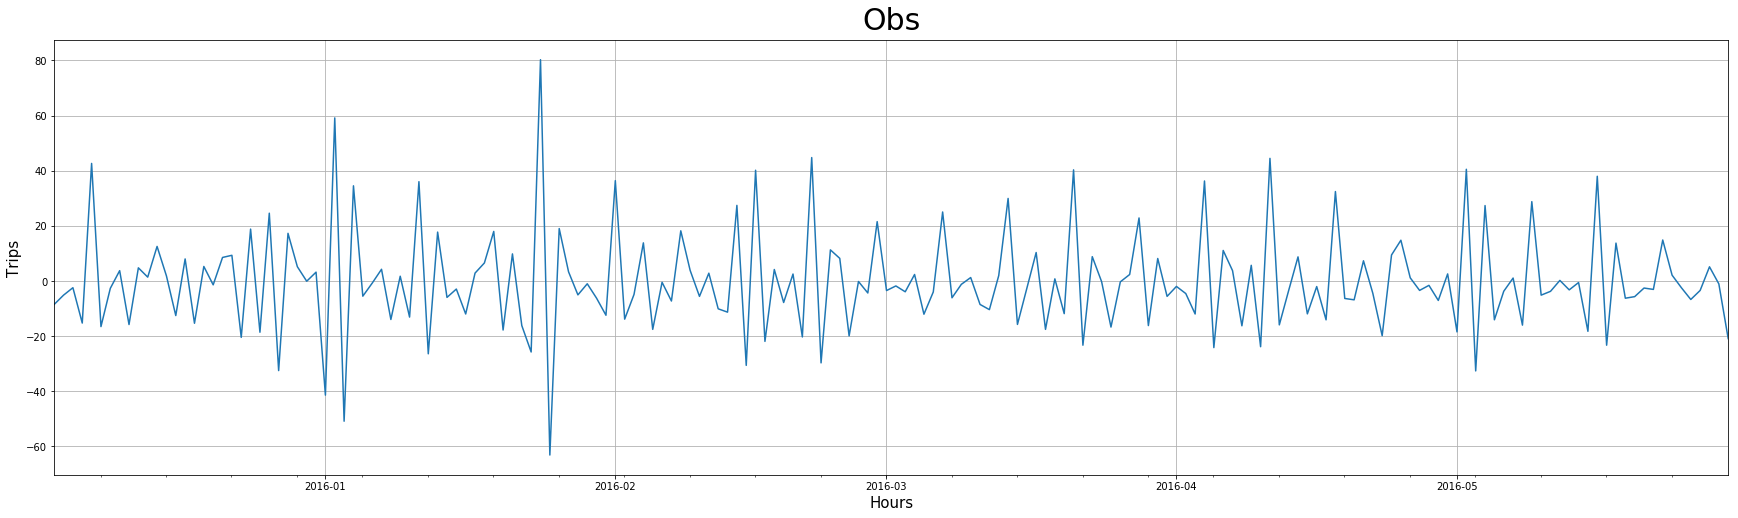

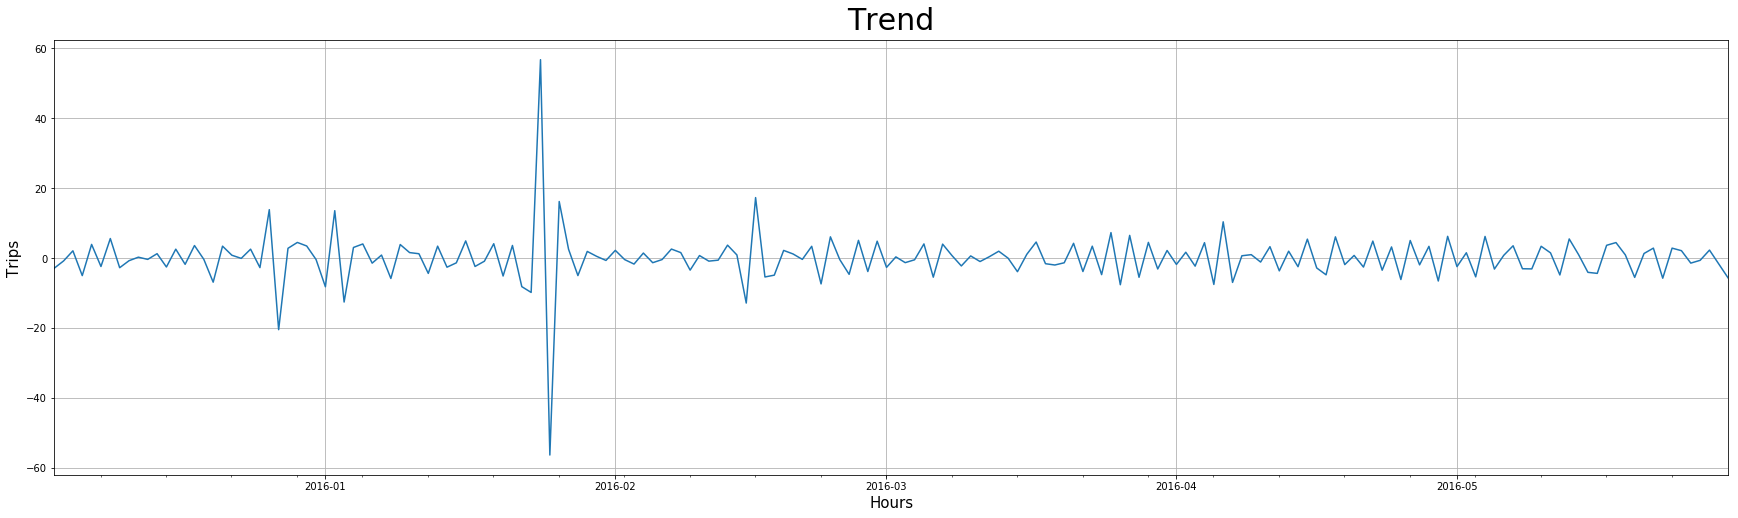

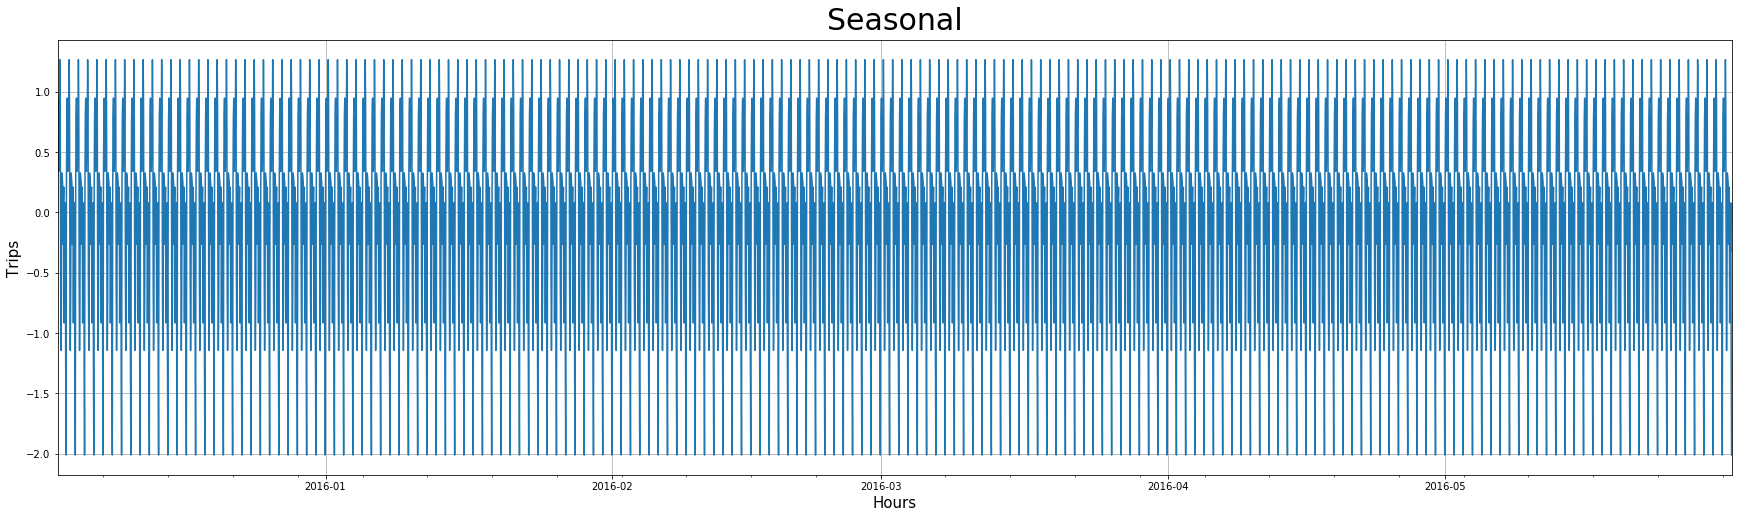

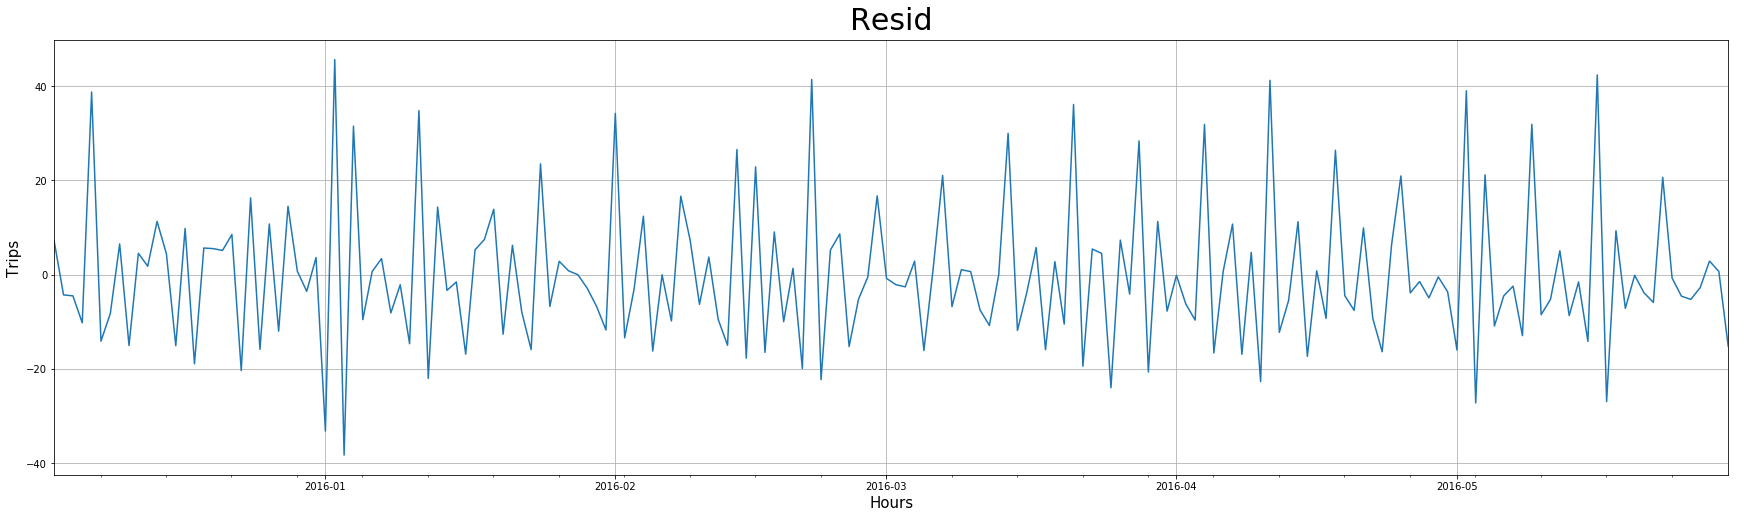

In [24]:
dec_plot(cell_data[diff_col].dropna())

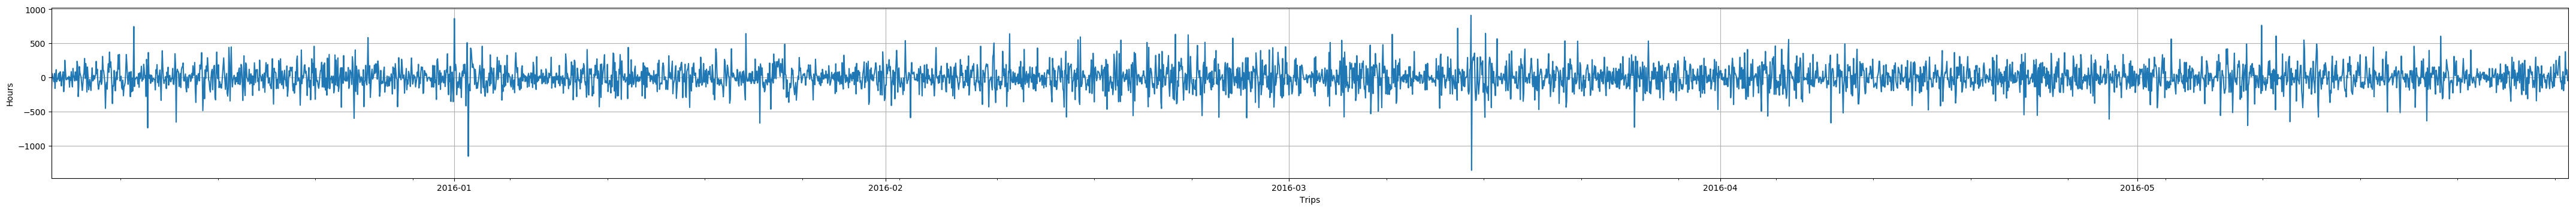

In [25]:
# Печать в отдельном окне.
temp_data = cell_data[diff_col].dropna()
window_plot(temp_data.index, np.array(temp_data))

В соответствии с заданием стационарность оцениваем пографикам. Тренда нет, дисперсия стабильна (если не считать аномалий), сезонности кроме суточной не вижу.

#### Выбор начальных приближений для p, q, P, Q

In [26]:
# Функция для печати в отдельном окне.
def window_autocor_plot(pd_series, lags, cor='acf', figsize=(100, 4)):
    """
    cor - тип авторкорелляции. 'acf' или 'pacf'.
    """
    
    global root, figure, frame, canvas, ax
    
    frame = None
    canvas = None
    ax = None
        
    root = Tk()
    root.rowconfigure(1, weight=1)
    root.columnconfigure(1, weight=1)

    frame = Frame(root)
    frame.grid(column=1, row=1, sticky=Tkconstants.NSEW)
    frame.rowconfigure(1, weight=1)
    frame.columnconfigure(1, weight=1)
    
    
    figure = plt.figure(dpi=100, figsize=figsize)
    ax = figure.add_subplot(111)
    if cor == 'acf':
        sm.graphics.tsa.plot_acf(pd_series.dropna().values.squeeze(), lags=lags, ax=ax)
    elif cor == 'pacf':
        sm.graphics.tsa.plot_pacf(pd_series.dropna().values.squeeze(), lags=lags, ax=ax)
    else:
        print('Wrong cor parameter')
    ax.xaxis.set_ticks(np.arange(0, lags, 10))
    ax.grid(True)
    addScrollingFigure(figure, frame)

    buttonFrame = Frame(root)
    buttonFrame.grid(row=1, column=2, sticky=Tkconstants.NS)
    biggerButton = Button(buttonFrame, text="larger",
                        command=lambda : changeSize(figure, 1.2))
    biggerButton.grid(column=1, row=1)
    smallerButton = Button(buttonFrame, text="smaller",
                         command=lambda : changeSize(figure, 0.833))
    smallerButton.grid(column=1, row=2)
    qButton = Button(buttonFrame, text="quit",
                         command=lambda :  sys.exit(0))
    qButton.grid(column=1, row=3)

    root.mainloop()

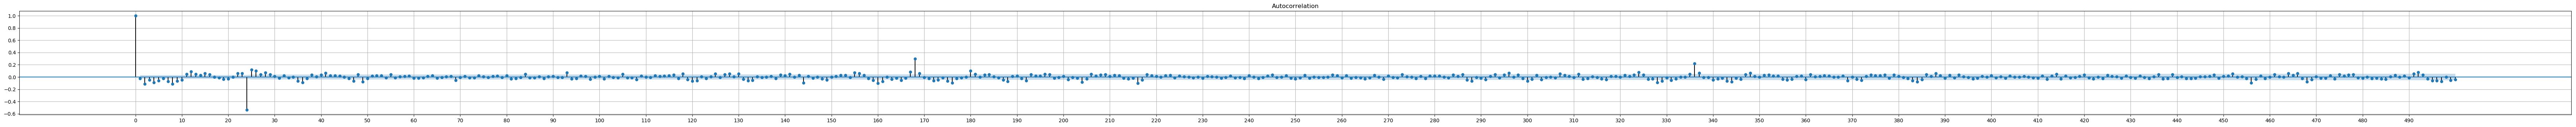

In [27]:
window_autocor_plot(cell_data[diff_col], lags=500, cor='acf')

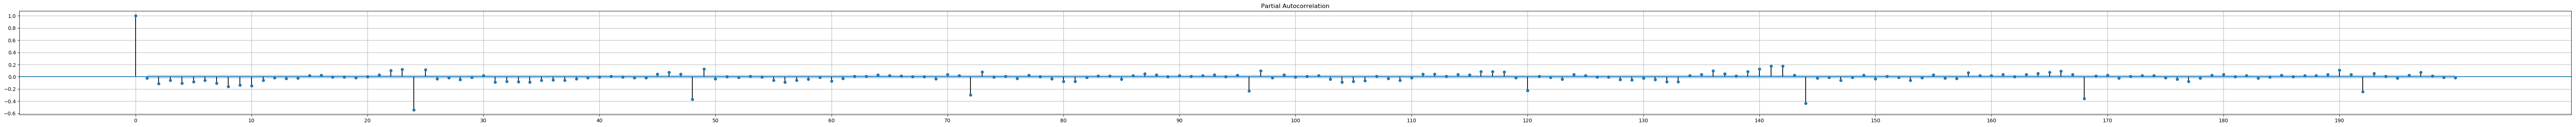

In [28]:
window_autocor_plot(cell_data[diff_col], lags=200, cor='pacf')

Принимаем следующие значения параметров:

In [29]:
p = 23
d = 1
q = 23
P = 7
D = 2
Q = 2

In [30]:
ps = [i for i in range(p+1)]
qs = [i for i in range(q+1)]
Ps = [i for i in range(P+1)]
Qs = [i for i in range(Q+1)]
parameters = product(ps, qs, Ps,Qs)
parameters = list(parameters)

In [ ]:
# Это ооочень долго.
import warnings
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')
print('Всего', str(len(parameters)))
i = 0
for param in parameters:
    i += 1
    print(i, '-', param, '...', datetime.datetime.now(), '...')
    try:
        model = sm.tsa.statespace.SARIMAX(cell_data['reg_resid'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit()
    
    except ValueError or np.linalg.LinAlgError or np.linalg.linalg.LinAlgError:
        print('...WRONG')
        continue
    aic_res = model.aic
    if aic_res < best_aic:
        best_model = model
        best_aic = aic_res
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

In [37]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                           reg_resid   No. Observations:                 4392
Model:             SARIMAX(5, 1, 15)x(1, 2, 0, 24)   Log Likelihood              -27272.092
Date:                             Tue, 28 May 2019   AIC                          54588.185
Time:                                     14:30:34   BIC                          54728.464
Sample:                                 12-01-2015   HQIC                         54637.703
                                      - 05-31-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9422      0.039    -24.250      0.000      -1.018      -0.866
ar.L2         -1.4492      0.049    -29.518      0.000      -1.545      -1.353
ar.L3         -1.3269      0.056    -23.506      0.000      -1.438      -1.216
ar.L4         -0.5898      0.048    -12.304      0.000      -0.684      -0.496
ar.L5         -0.5056      0.039    -13.108      0.000      -0.581      -0.430
ma.L1          0.9018      4.675      0.193      0.847      -8.262      10.065
ma.L2          1.3006      8.889      0.146      0.884     -16.122      18.723
ma.L3          1.0263     14.973      0.069      0.945     -28.320      30.372
ma.L4         -0.1118     19.771     -0.006      0.995     -38.862      38.639
ma.L5         -0.3427     19.252     -0.018      0.986     -38.076      37.390
ma.L6         -0.9299     17.653     -0.053      0.958     -35.530      33.670
ma.L7         -0.9165     13.306     -0.069      0.945     -26.996      25.163
ma.L8         -0.7768      9.024     -0.086      0.931     -18.463      16.910
ma.L9         -0.6409      5.392     -0.119      0.905     -11.210       9.928
ma.L10        -0.6859      2.397     -0.286      0.775      -5.384       4.012
ma.L11        -0.4744      0.812     -0.584      0.559      -2.066       1.117
ma.L12        -0.1060      3.028     -0.035      0.972      -6.042       5.830
ma.L13         0.0810      3.527      0.023      0.982      -6.832       6.994
ma.L14         0.3100      3.151      0.098      0.922      -5.866       6.487
ma.L15         0.3652      1.704      0.214      0.830      -2.975       3.706
ar.S.L24      -0.5090      0.021    -24.284      0.000      -0.550      -0.468
sigma2       2.59e+04   1.21e+05      0.214      0.831   -2.11e+05    2.63e+05
===================================================================================
Ljung-Box (Q):                      439.34   Jarque-Bera (JB):               504.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.03
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.68e+14. Standard errors may be unstable.
"""

Подобранные параметры.

In [38]:
params = results[0][0]
p = params[0]
q = params[1]
P = params[2]
Q = params[3]
print('p = {}, d = {}, q = {}, P = {}, D = {}, Q = {}'.format(p, d, q, P, D, Q))

p = 5, d = 1, q = 15, P = 1, D = 2, Q = 0


Получили предсказания и остатки.

In [39]:
cell_data['fitted_values'] = best_model.fittedvalues
cell_data['resid'] = best_model.resid
cell_data['pred'] = cell_data['reg_pred'] +  cell_data['fitted_values']

Принимаем следующие значения параметров:

#### Анализ остатков

Критерий Стьюдента: p=0.95
Критерий Дики-Фуллера: p=3.266515785121686e-25
Критерий Льюнга-Бокса: p=0.0


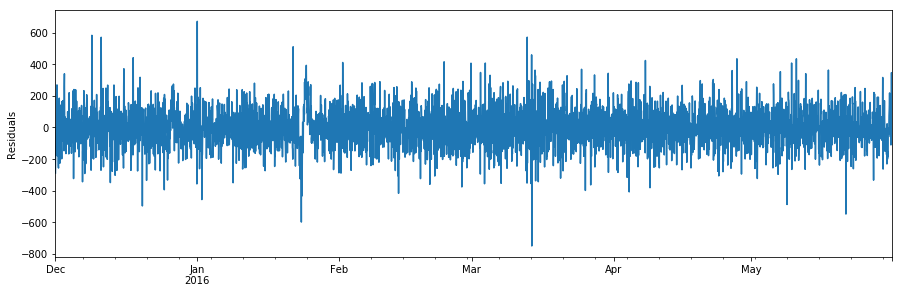

In [40]:
plt.figure(figsize=(15,10))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel('Residuals')

#ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=50, ax=ax)

print('Критерий Стьюдента: p={:.2f}'.format(sts.ttest_1samp(best_model.resid.dropna(), 0)[1]))
print('Критерий Дики-Фуллера: p={}'.format(sm.tsa.stattools.adfuller(best_model.resid.dropna())[1]))
print('Критерий Льюнга-Бокса: p={}'.format(float(str(best_model.summary().tables[2]).split()[8])))

plt.show()

В остатках видна структура в аномальный период.

### 5. Предсказание. Анализ результатов.

In [41]:
# Печать в отдельном окне.
def window_fitted_plot(labels, trips, preds, min_lim=None, max_lim=None, title=''):
    
    global root, figure, frame, canvas, ax
    
    frame = None
    canvas = None
    ax = None
    
    if min_lim is None:
        min_lim = labels[0]
    else:
        min_lim = datetime.datetime.strptime(min_lim, '%Y-%m-%d %H:%M:%S')
    
    if max_lim is None:
        max_lim = labels[-1]
    else:
        max_lim = datetime.datetime.strptime(max_lim, '%Y-%m-%d %H:%M:%S')
    
    root = Tk()
    root.rowconfigure(1, weight=1)
    root.columnconfigure(1, weight=1)

    frame = Frame(root)
    frame.grid(column=1, row=1, sticky=Tkconstants.NSEW)
    frame.rowconfigure(1, weight=1)
    frame.columnconfigure(1, weight=1)
    
    
    figure = plt.figure(dpi=100, figsize=(60, 4))
    ax = figure.add_subplot(111)
    ax.plot(labels, trips)
    ax.plot(labels, preds, color='r')
    ax.set_xlim(min_lim, max_lim)
    ax.set_title(title)
    ax.set_xlabel('Trips')
    ax.set_ylabel('Hours')
    
    month = mdates.MonthLocator()
    month_format = mdates.DateFormatter('%Y-%m')
    week_day = mdates.WeekdayLocator()
    ax.xaxis.set_major_locator(month)
    ax.xaxis.set_major_formatter(month_format)
    ax.xaxis.set_minor_locator(week_day)
    ax.grid(True)
    
    addScrollingFigure(figure, frame)

    buttonFrame = Frame(root)
    buttonFrame.grid(row=1, column=2, sticky=Tkconstants.NS)
    biggerButton = Button(buttonFrame, text="larger",
                        command=lambda : changeSize(figure, 1.2))
    biggerButton.grid(column=1, row=1)
    smallerButton = Button(buttonFrame, text="smaller",
                         command=lambda : changeSize(figure, 0.833))
    smallerButton.grid(column=1, row=2)
    qButton = Button(buttonFrame, text="quit",
                         command=lambda :  sys.exit(0))
    qButton.grid(column=1, row=3)

    root.mainloop()

In [42]:
def simple_fitted_plot(labels, trips, preds, min_lim=None, max_lim=None, title=''):
    """
    labels -список с datetime.datetime объектами
    min_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Минимальная дата отрисовки
    max_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Максимальная дата отрисовки
    title - заголовок
    """
    month = mdates.MonthLocator()
    month_format = mdates.DateFormatter('%Y-%m')
    week_day = mdates.WeekdayLocator()
    
    
    if min_lim is None:
        min_lim = labels[0]
    else:
        min_lim = datetime.datetime.strptime(min_lim, '%Y-%m-%d %H:%M:%S')
    
    if max_lim is None:
        max_lim = labels[-1]
    else:
        max_lim = datetime.datetime.strptime(max_lim, '%Y-%m-%d %H:%M:%S')
    
    fig, ax = plt.subplots(figsize=(30, 8))
    ax.plot(labels, trips)
    ax.plot(labels, preds, color='r')
    ax.set_xlabel('Hours', fontsize=15)
    #plt.xticks(plot_hours[::label_step], plot_labels[::label_step], rotation='vertical')
    ax.set_ylabel('Trips', fontsize=15)
    ax.xaxis.set_major_locator(month)
    ax.xaxis.set_major_formatter(month_format)
    ax.xaxis.set_minor_locator(week_day)
    """
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('left')
    """
    ax.grid(True)
    ax.set_xlim(min_lim, max_lim)
    ax.set_title(title, fontsize=30, y=1.01)

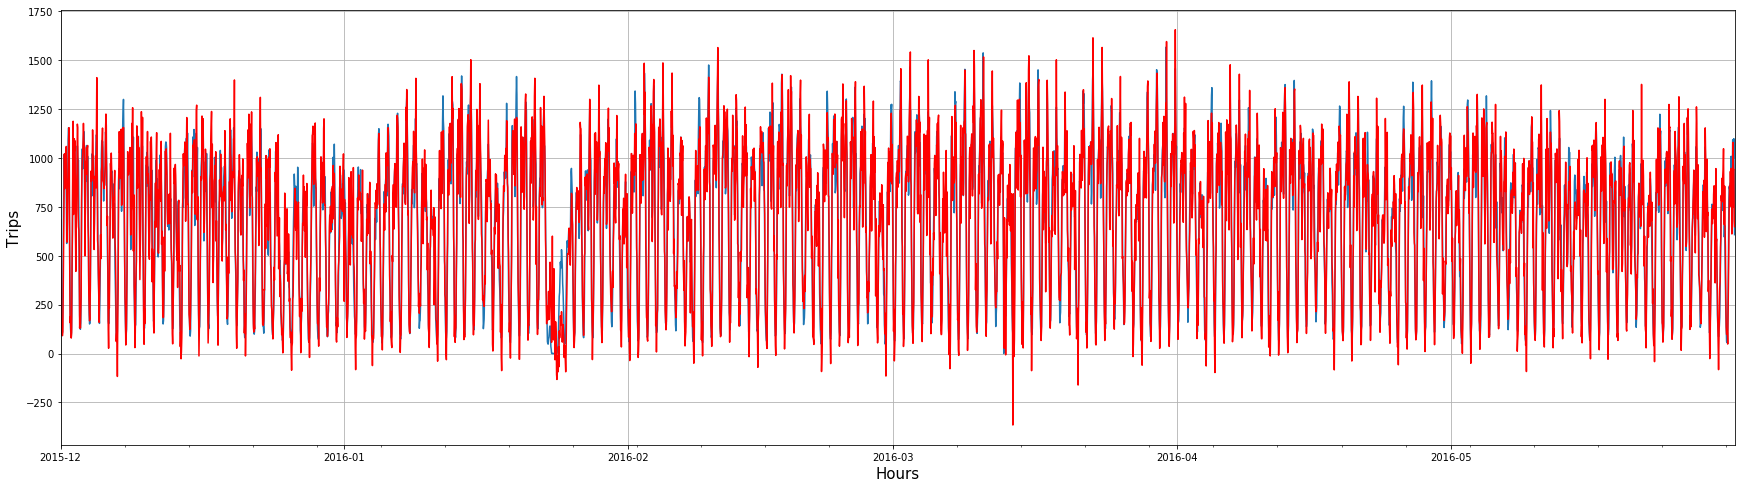

In [43]:
simple_fitted_plot(labels, np.array(cell_data['trips']), 
                   np.array(cell_data['pred']))

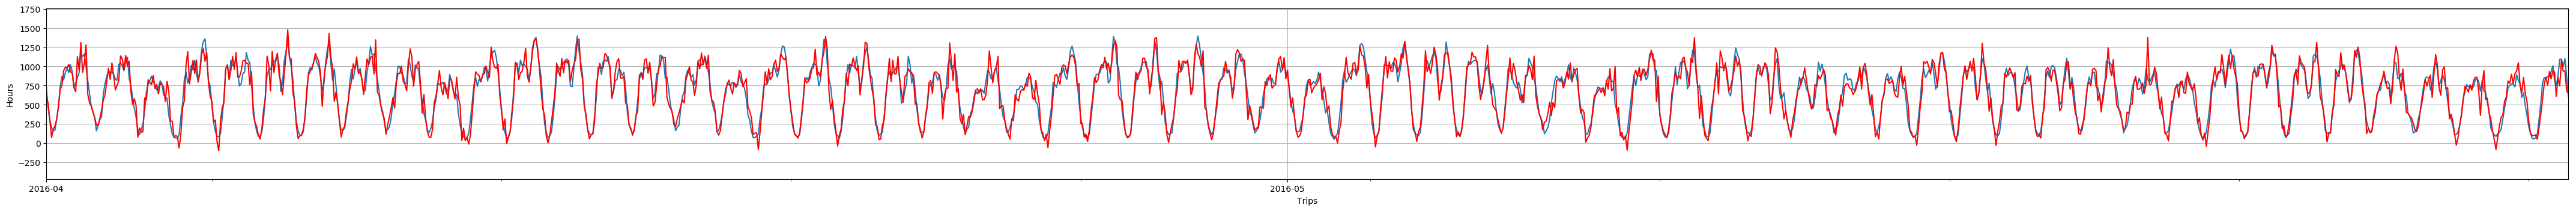

In [44]:
window_fitted_plot(labels, np.array(cell_data['trips']), 
                   np.array(cell_data['pred']), 
                   min_lim='2016-04-01 00:00:00')

Результат полохо описывает данные в аномальной зоне, и в целом так себе. Попробуем увеличить значение К, и добавить новые признаки.

### 6. Доп. признаки.

Увеличим К, добавим категориальные признаки месяца, дня недели, логарифм количества дней с прошедшего праздника.

Примем К=20.

In [47]:
cell_data.drop(columns=features_columns + ['reg_pred', 'reg_resid', 'reg_resid_diff', 'fitted_values', 'pred', 'resid'], inplace=True)

In [17]:
# Количество дней до ближайшего праздника. Не использовалось.
def day_before_holiday(day):
    ny_holidays = holidays.CountryHoliday('US', state='NY')
    res = 0
    temp_day = day
    while temp_day not in ny_holidays:
        res += 1
        temp_day = temp_day + datetime.timedelta(days=1)
    return res

In [18]:
# Количество дней после ближайшего прошедшего праздника.
def day_after_holiday(day):
    ny_holidays = holidays.CountryHoliday('US', state='NY')
    res = 0
    temp_day = day
    while temp_day not in ny_holidays:
        res += 1
        temp_day = temp_day - datetime.timedelta(days=1)
    return res

In [19]:
# Добавление признаков. 
# Модифицирует датафрейм, возвращеет имена колонок с признаками.
def add_features(cell_data, k):
    
    # Синусы и косинусы.
    cell_data['const'] = 1
    cell_data['lin'] = np.arange(1, cell_data.shape[0]+1)
    real_columns = ['const', 'lin']
    for i in range(1, k+1):
        #year_sin_col = 'year_sin_{}'.format(i)
        #year_cos_col = 'year_cos_{}'.format(i)
        week_sin_col = 'week_sin_{}'.format(i)
        week_cos_col = 'week_cos_{}'.format(i)
        
        #cell_data[year_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 8766))
        #cell_data[year_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 8766))
        cell_data[week_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 168))
        cell_data[week_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 168))
        
        #features_columns += [year_sin_col, year_cos_col, week_sin_col, week_cos_col]
        real_columns += [week_sin_col, week_cos_col]
    
    # Дни недели.
    weekdays = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    days = cell_data.index
    days = np.array([i.weekday() + 1 for i in days])
    res = OneHotEncoder(sparse=False).fit_transform(days.reshape((-1,1)))
    for i in range(len(weekdays)):
        cell_data[weekdays[i]] = res[:, i]
    categorical_columns = weekdays
    
    # Месяцы. 
    #months_names = ['january', 'february', 'march', 'april', 'may', 'june', 
              #'jule', 'august', 'september', 'october', 'november', 'december']
    months_names = ['december', 'january', 'february', 'march', 'april', 'may']
    months = cell_data.index
    months = np.array([i.month%12 + 1 for i in months])
    res = OneHotEncoder(sparse=False).fit_transform(months.reshape((-1,1)))
    for i in range(len(months_names)):
        cell_data[months_names[i]] = res[:, i]
    categorical_columns += months_names
    
    # Праздники.
    cell_data['days_after_holidays'] = np.log(np.array([day_after_holiday(i) for i in cell_data.index]) + 1)
    real_columns += ['days_after_holidays']
    
    # Масштабирование.
    #vals = StandardScaler().fit_transform(np.array(cell_data[real_columns]))
    #for i in range(len(real_columns)):
     #   cell_data[real_columns[i]] = vals[:, i]
    
    features_columns = real_columns + categorical_columns
    
    return features_columns

In [22]:
K = 20
features_columns = add_features(cell_data, K)
reg_pred = get_reg_pred(cell_data, features_columns)
cell_data['reg_resid'] = cell_data['trips'] - reg_pred
cell_data.head()

/home/artem/data_science/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/artem/data_science/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can spe

trips  const  lin  week_sin_1  week_cos_1  week_sin_2  \
2015-12-01 00:00:00  394.0      1    1    0.037391    0.999301    0.074730   
2015-12-01 01:00:00  185.0      1    2    0.074730    0.997204    0.149042   
2015-12-01 02:00:00  109.0      1    3    0.111964    0.993712    0.222521   
2015-12-01 03:00:00  100.0      1    4    0.149042    0.988831    0.294755   
2015-12-01 04:00:00   92.0      1    5    0.185912    0.982566    0.365341   

                     week_cos_2  week_sin_3  week_cos_3  week_sin_4  ...  \
2015-12-01 00:00:00    0.997204    0.111964    0.993712    0.149042  ...   
2015-12-01 01:00:00    0.988831    0.222521    0.974928    0.294755  ...   
2015-12-01 02:00:00    0.974928    0.330279    0.943883    0.433884  ...   
2015-12-01 03:00:00    0.955573    0.433884    0.900969    0.563320  ...   
2015-12-01 04:00:00    0.930874    0.532032    0.846724    0.680173  ...   

                     sunday  december  january  february  march  april  may  \
2015-12-01 00:00:00     0.0       1.0      0.0       0.0    0.0    0.0  0.0   
2015-12-01 01:00:00     0.0       1.0      0.0       0.0    0.0    0.0  0.0   
2015-12-01 02:00:00     0.0       1.0      0.0       0.0    0.0    0.0  0.0   
2015-12-01 03:00:00     0.0       1.0      0.0       0.0    0.0    0.0  0.0   
2015-12-01 04:00:00     0.0       1.0      0.0       0.0    0.0    0.0  0.0   

                     days_after_holidays    reg_pred  reg_resid  
2015-12-01 00:00:00             1.791759  423.515988 -29.515988  
2015-12-01 01:00:00             1.791759  218.525725 -33.525725  
2015-12-01 02:00:00             1.791759   74.667252  34.332748  
2015-12-01 03:00:00             1.791759   13.542186  86.457814  
2015-12-01 04:00:00             1.791759   41.893454  50.106546  

[5 rows x 59 columns]

Два раза продифференцируем по cуточной сезонности. Затем применим обычное дифференцирование.

In [25]:
diff_period = 24
resid_col = 'reg_resid'
diff_col = 'reg_resid_diff' 
cell_data[diff_col] = cell_data[resid_col] - cell_data[resid_col].shift(diff_period)
cell_data[diff_col] = cell_data[diff_col] - cell_data[diff_col].shift(diff_period)
cell_data[diff_col] = cell_data[diff_col] - cell_data[diff_col].shift(1)

#### Выбор начальных приближений для p, q, P, Q

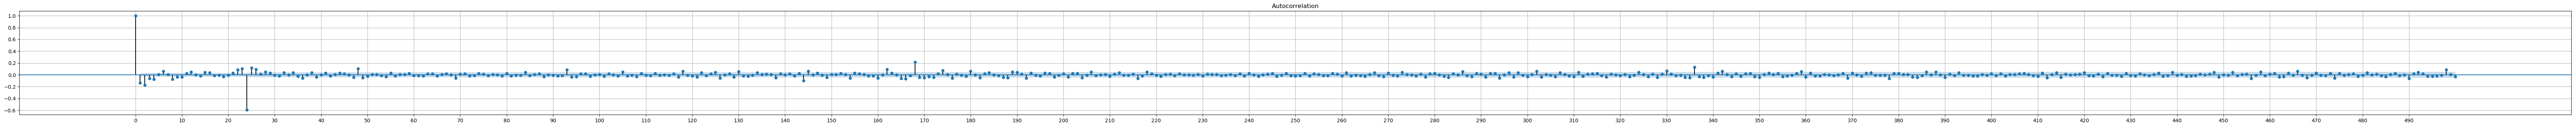

In [29]:
window_autocor_plot(cell_data[diff_col], lags=500, cor='acf')

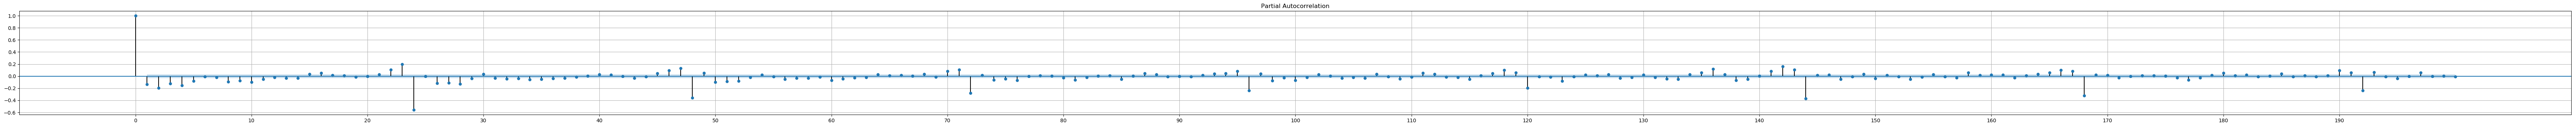

In [30]:
window_autocor_plot(cell_data[diff_col], lags=200, cor='pacf')

Принимаем следующие значения параметров:

In [31]:
p = 23
d = 1
q = 23
P = 7
D = 2
Q = 2

In [32]:
ps = [i for i in range(p+1)]
qs = [i for i in range(q+1)]
Ps = [i for i in range(P+1)]
Qs = [i for i in range(Q+1)]
parameters = product(ps, qs, Ps,Qs)
parameters = list(parameters)

In [ ]:
# Это ооочень долго.
import warnings
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')
print('Всего', str(len(parameters)))
i = 0
for param in parameters:
    i += 1
    print(i, '-', param, '...', datetime.datetime.now(), '...')
    try:
        model = sm.tsa.statespace.SARIMAX(cell_data['reg_resid'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit()
    
    except ValueError or np.linalg.LinAlgError or np.linalg.linalg.LinAlgError:
        print('...WRONG')
        continue
    aic_res = model.aic
    if aic_res < best_aic:
        best_model = model
        best_aic = aic_res
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

In [37]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                  
============================================================================================
Dep. Variable:                            reg_resid   No. Observations:                 4392
Model:             SARIMAX(21, 1, 22)x(0, 2, 0, 24)   Log Likelihood              -26690.354
Date:                              Tue, 28 May 2019   AIC                          53468.709
Time:                                      11:11:38   BIC                          53749.267
Sample:                                  12-01-2015   HQIC                         53567.745
                                       - 05-31-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1851      0.105     -1.759      0.079      -0.391       0.021
ar.L2         -0.0941      0.080     -1.169      0.242      -0.252       0.064
ar.L3         -0.1730      0.070     -2.479      0.013      -0.310      -0.036
ar.L4          0.5157      0.059      8.790      0.000       0.401       0.631
ar.L5         -0.0082      0.041     -0.199      0.842      -0.089       0.073
ar.L6         -0.6115      0.040    -15.396      0.000      -0.689      -0.534
ar.L7         -0.0958      0.077     -1.240      0.215      -0.247       0.056
ar.L8         -0.1087      0.065     -1.683      0.092      -0.235       0.018
ar.L9         -0.1039      0.058     -1.778      0.075      -0.218       0.011
ar.L10         0.3261      0.056      5.793      0.000       0.216       0.436
ar.L11        -0.0153      0.048     -0.318      0.751      -0.110       0.079
ar.L12        -0.2605      0.045     -5.837      0.000      -0.348      -0.173
ar.L13        -0.0083      0.052     -0.159      0.873      -0.110       0.093
ar.L14        -0.1119      0.049     -2.286      0.022      -0.208      -0.016
ar.L15         0.0457      0.049      0.942      0.346      -0.049       0.141
ar.L16         0.2086      0.045      4.674      0.000       0.121       0.296
ar.L17        -0.0434      0.043     -0.997      0.319      -0.129       0.042
ar.L18         0.0279      0.039      0.722      0.470      -0.048       0.104
ar.L19        -0.0354      0.038     -0.924      0.356      -0.111       0.040
ar.L20        -0.2027      0.038     -5.323      0.000      -0.277      -0.128
ar.L21         0.0646      0.050      1.303      0.193      -0.033       0.162
ma.L1          0.0081      0.662      0.012      0.990      -1.288       1.305
ma.L2         -0.2554      0.643     -0.397      0.691      -1.516       1.006
ma.L3         -0.0085      0.481     -0.018      0.986      -0.951       0.934
ma.L4         -0.7756      0.491     -1.580      0.114      -1.738       0.186
ma.L5         -0.0065      0.208     -0.031      0.975      -0.414       0.401
ma.L6          1.0397      0.153      6.804      0.000       0.740       1.339
ma.L7          0.0176      0.673      0.026      0.979      -1.301       1.336
ma.L8         -0.2500      0.694     -0.360      0.719      -1.609       1.109
ma.L9         -0.0038      0.501     -0.008      0.994      -0.986       0.978
ma.L10        -0.8059      0.519     -1.554      0.120      -1.822       0.211
ma.L11         0.0042      0.215      0.019      0.984      -0.417       0.426
ma.L12         1.0475      0.117      8.948      0.000       0.818       1.277
ma.L13         0.0102      0.682      0.015      0.988      -1.327       1.347
ma.L14        -0.2184      0.684     -0.319      0.749      -1.559       1.122
ma.L15        -0.0157      0.525     -0.030      0.976      -1.045       1.013
ma.L16        -0.8225      0.530  

Подобранные параметры.

In [38]:
params = results[0][0]
p = params[0]
q = params[1]
P = params[2]
Q = params[3]
print('p = {}, d = {}, q = {}, P = {}, D = {}, Q = {}'.format(p, d, q, P, D, Q))

p = 21, d = 1, q = 22, P = 0, D = 2, Q = 0


Получили предсказания и остатки.

In [40]:
cell_data['fitted_values'] = best_model.fittedvalues
cell_data['resid'] = best_model.resid
cell_data['pred'] = cell_data['reg_pred'] +  cell_data['fitted_values']

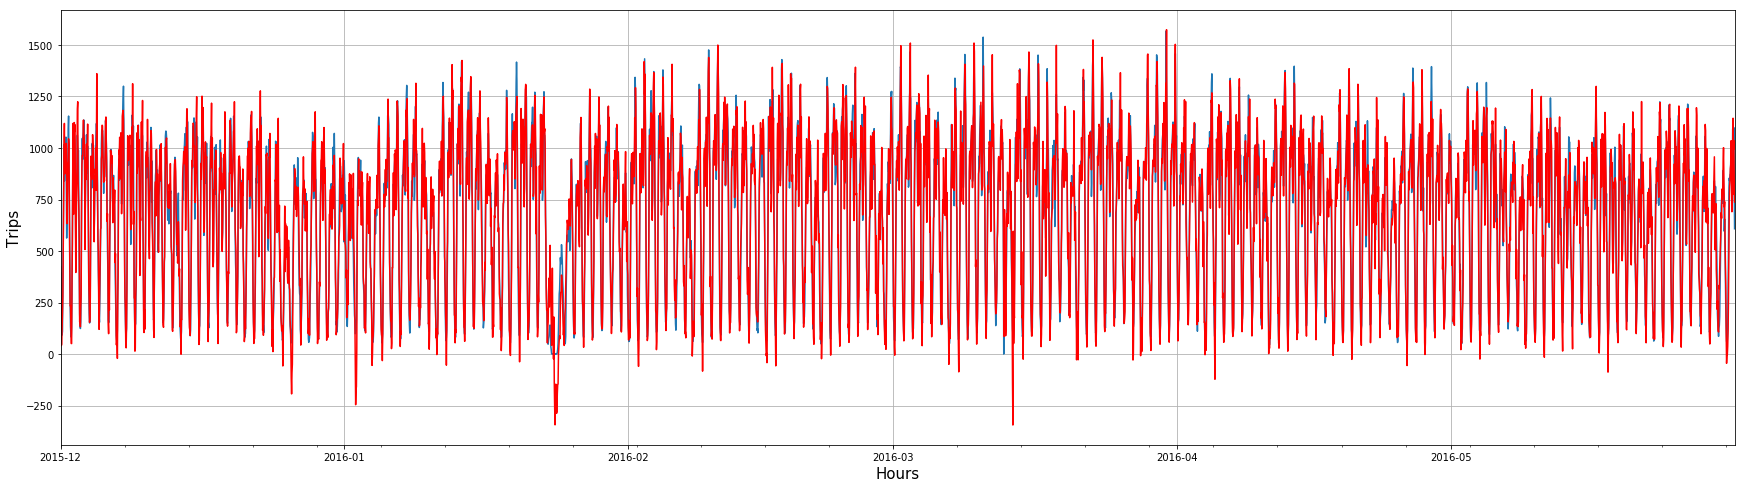

In [48]:
simple_fitted_plot(labels, np.array(cell_data['trips']), 
                   np.array(cell_data['pred']))

Уже лучше, но все равно плохо описан аномальный период. Для первого приближения оставлю пока так: перебор параметров аримы на моем ноутбуке занимает ооочень много времени. Тем более, тут вообще можно отказаться от этой модели и все делать регрессией.